In [2]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# notebook/ 的父目录
root = Path.cwd().parent 
sys.path.insert(0, str(root))

import tifffile
import numpy as np

from utils_io import get_scanimage_frame_times, read_rotary_log

#auto reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Visualize mean frames from z-stack

In [3]:
import numpy as np

def extract_mean_frame(data: np.ndarray,
                       num_v: int,
                       num_s: int,
                       num_f: int,
                       *, dtype=np.float32,
                       check=True) -> np.ndarray:
    """
    Average across ALL volumes and frames.
    Output: one mean image per stack/plane.

    Assumed order (fastest -> slowest):
        frame -> stack -> volume

    Parameters
    ----------
    data : ndarray
        Shape (T, Y, X)
    num_v : int
        Number of volumes
    num_s : int
        Number of stacks / planes
    num_f : int
        Frames per plane
    dtype : dtype
        Accumulation dtype
    check : bool
        Validate frame count

    Returns
    -------
    mean_frames : ndarray
        Shape (num_s, Y, X)
    """
    if data.ndim != 3:
        raise ValueError(f"Expected (T,Y,X), got {data.shape}")

    T, Y, X = data.shape
    expected = num_v * num_s * num_f
    if check and T != expected:
        raise ValueError(
            f"Frame mismatch: T={T}, expected {expected} "
            f"(num_v={num_v}, num_s={num_s}, num_f={num_f})"
        )

    # (T,Y,X) → (V,S,F,Y,X)
    data = data.astype(dtype, copy=False)
    reshaped = data.reshape(num_v, num_s, num_f, Y, X)

    # average over volume and frame
    mean_frames = reshaped.mean(axis=(0, 2))  # (S,Y,X)

    return mean_frames


shape: (8200, 512, 512)


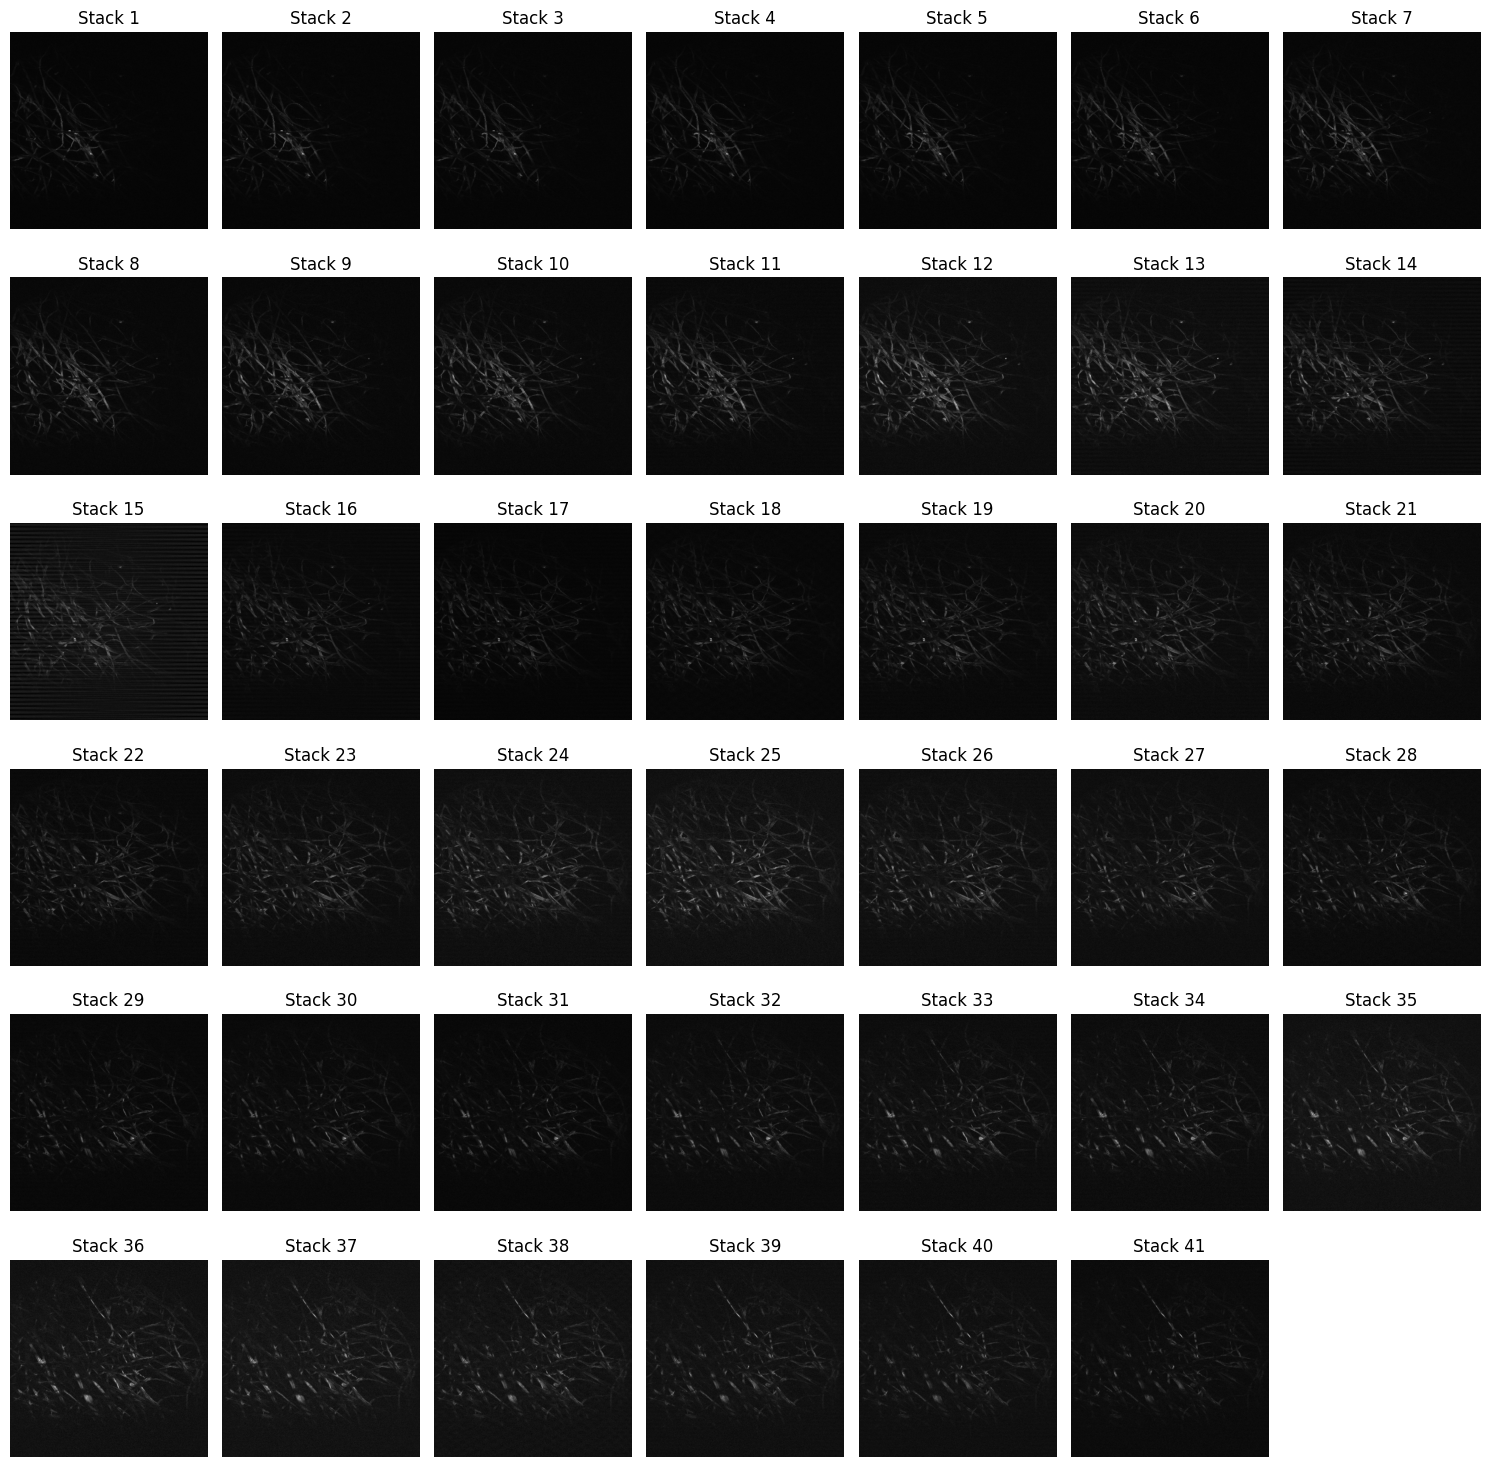

In [4]:
# read a tiff file and plot the images

# path = r"D:\data\935\20260205\stack_00001.tif"

# path = r"D:\data\724\08112024_session_00002.tif"

path = r"D:\data\test\stack_00001.tif"

data = tifffile.imread(path)

print("shape:", data.shape)

mean_frames = extract_mean_frame(data, num_v=1, num_s=41, num_f=200, dtype=np.float32, check=True)

import matplotlib.pyplot as plt
#show 21 mean frames in a 3x7 grid
fig, axes = plt.subplots(6, 7, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < mean_frames.shape[0]:
        ax.imshow(mean_frames[i], cmap='gray')
        ax.set_title(f'Stack {i+1}')
    ax.axis('off')
plt.tight_layout()

### Get stack tiff time

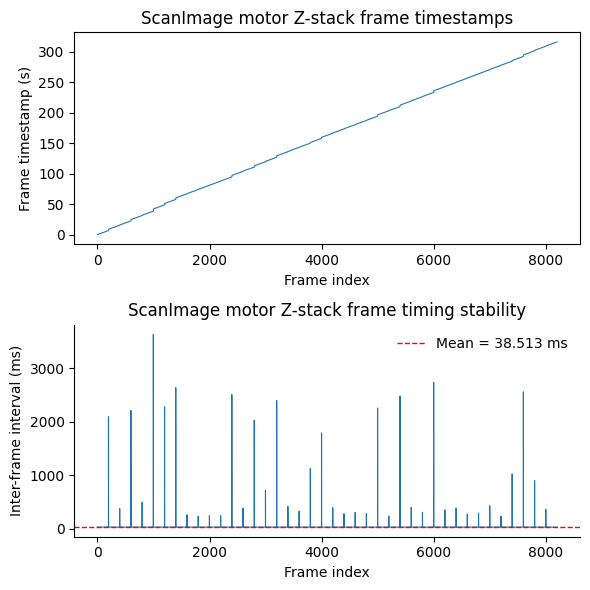

In [12]:
# tif_path = r"D:\data\935\20260205\stack_00001.tif"

tif_path = r"D:\data\test\stack_00001.tif"

tA_rel, tA_wall = get_scanimage_frame_times(tif_path)

dt = np.diff(tA_rel) * 1000 # convert to ms
fig, axs = plt.subplots(2,1, figsize=(6, 6))

ax = axs[0]
ax.plot(tA_rel, lw=0.8)
ax.set_xlabel("Frame index")
ax.set_ylabel("Frame timestamp (s)")
ax.set_title("ScanImage motor Z-stack frame timestamps")

ax = axs[1]
ax.plot(dt, lw=0.8)

ax.set_xlabel("Frame index")
ax.set_ylabel("Inter-frame interval (ms)")
ax.set_title("ScanImage motor Z-stack frame timing stability")

# 显示统计量
mean_dt = dt.mean()
std_dt  = dt.std()

ax.axhline(mean_dt, color="r", ls="--", lw=1,
           label=f"Mean = {mean_dt:.3f} ms")

ax.legend(frameon=False)

# 美化
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


### get the angel for each frame

In [2]:

tif_path = r"D:\data\test\stack_00001.tif"
rotary_log_path = r"D:\data\test\rotary_stream_20260211_114354.txt"
tA_rel, tA_wall = get_scanimage_frame_times(tif_path)
dt_list, mono_list, angle_list = read_rotary_log(rotary_log_path, tA_wall)

In [10]:
# Map rotary angles to each tA_wall timestamp
# tA_wall: numpy datetime64[ns] array
# dt_list, angle_list from read_rotary_log
import numpy as np

angle_arr = np.asarray(angle_list, dtype=float)

dt_arr = np.array(dt_list, dtype='datetime64[ns]')

if len(tA_wall) == 0:
    angle_at_tA = np.array([], dtype=float)
else:
    idx = np.searchsorted(dt_arr, tA_wall, side='left')
    idx = np.clip(idx, 0, len(dt_arr) - 1)

    prev_idx = np.clip(idx - 1, 0, len(dt_arr) - 1)
    use_prev = (idx > 0) & (np.abs(tA_wall - dt_arr[prev_idx]) <= np.abs(tA_wall - dt_arr[idx]))
    idx[use_prev] = prev_idx[use_prev]

    angle_at_tA = angle_arr[idx]



## Merge into a function to get angles correspodning to each frame

In [2]:
from utils_io import get_frame_angles_from_rotary

In [14]:
tif_path = r"D:\data\test\stack_00001.tif"
rotary_log_path = r"D:\data\test\rotary_stream_20260211_114354.txt"
angle_at_tA, tA_rel, tA_wall = get_frame_angles_from_rotary(tif_path, rotary_log_path)


### get mean satck after inage registration

In [13]:
import time
from utils_image import cropLargestRecT, UnrotateCropFrame, RegFrame
from PIL import Image
import cv2
from utils_io import get_frame_angles_from_rotary


def get_meanframe_from_Zstacks(frames, angles, volume, stacks, frames_per_stack, Rotcenter, ImgReg=False):
    """
    Compute mean Z-stack frames after un-rotation and cropping.

    frames: np.ndarray [n_frames, Ly, Lx]
    angles: array-like length n_frames
    volume: int
    stacks: int
    frames_per_stack: int  (frames per stack per volume)
    Rotcenter: [x, y]
    ImgReg: bool
    """
    print("Extract the mean frame of Zstacks...")
    t0 = time.time()

    n_frames = frames.shape[0]
    expected = volume * stacks * frames_per_stack
    if n_frames != expected:
        raise ValueError(f"Actual frames: got {n_frames}, expected {expected}")

    # determine output size from first frame
    unrot = Image.fromarray(frames[0]).rotate(angles[0], center=Rotcenter)
    cropped = cropLargestRecT(unrot, Rotcenter)
    w, h = cropped.size

    meanZstacks = np.zeros((stacks, h, w), dtype=np.int16)

    for stack_i in range(stacks):
        print(f"Processing stack {stack_i}")

        # indices for this stack across all volumes
        inds = np.zeros((volume * frames_per_stack), dtype=np.int32)
        for vi in range(volume):
            start = vi * stacks * frames_per_stack + stack_i * frames_per_stack
            inds[vi * frames_per_stack:(vi + 1) * frames_per_stack] = np.arange(
                start, start + frames_per_stack, 1
            )

        # batch unrotate + crop for this stack
        stack_frames = frames[inds]
        stack_angles = angles[inds]
        temp_stack_frames = UnrotateCropFrame(stack_frames, stack_angles, Rotcenter)

        if ImgReg:
            meanImg, _ = RegFrame(temp_stack_frames)
        else:
            meanImg = np.mean(temp_stack_frames, axis=0)

        meanZstacks[stack_i] = meanImg.astype(np.int16)

    print("Getting the mean Z stack frames -- Done! Time used: {}".format(time.time() - t0))
    return meanZstacks


def get_meanframe_from_Zstacks_cv2(frames, angles, volume, stacks, frames_per_stack, Rotcenter, ImgReg=False):
    """
    OpenCV-accelerated version.
    Requires: cv2
    """
    print("Extract the mean frame of Zstacks (OpenCV)...")
    t0 = time.time()

    frames = np.asarray(frames)
    angles = np.asarray(angles, dtype=float)

    n_frames = frames.shape[0]
    expected = volume * stacks * frames_per_stack
    if n_frames != expected:
        raise ValueError(f"Actual frames: got {n_frames}, expected {expected}")

    # OpenCV expects center = (x, y) = (col, row)
    h0, w0 = frames[0].shape[:2]
    cx = float(Rotcenter[1])
    cy = float(Rotcenter[0])
    Rotcenter_cv = (cx, cy)

    # precompute crop box (same for all frames)
    minval = min(cx, w0 - cx, cy, h0 - cy)
    maxHalfSize = int(np.floor(np.sqrt(2) * minval / 2.0))
    left = int(round(cx - maxHalfSize))
    right = int(round(cx + maxHalfSize))
    upper = int(round(cy - maxHalfSize))
    lower = int(round(cy + maxHalfSize))

    out_h = lower - upper
    out_w = right - left
    meanZstacks = np.zeros((stacks, out_h, out_w), dtype=np.int16)

    for stack_i in range(stacks):
        print(f"Processing stack {stack_i}")

        inds = np.zeros((volume * frames_per_stack), dtype=np.int32)
        for vi in range(volume):
            start = vi * stacks * frames_per_stack + stack_i * frames_per_stack
            inds[vi * frames_per_stack:(vi + 1) * frames_per_stack] = np.arange(
                start, start + frames_per_stack, 1
            )

        temp = np.zeros((len(inds), out_h, out_w), dtype=np.float32)
        for i, ind in enumerate(inds):
            frame = frames[ind]
            angle = angles[ind]

            M = cv2.getRotationMatrix2D(Rotcenter_cv, angle, 1.0)
            rotated = cv2.warpAffine(frame, M, (w0, h0), flags=cv2.INTER_LINEAR)
            temp[i] = rotated[upper:lower, left:right]

        if ImgReg:
            meanImg, _ = RegFrame(temp)
        else:
            meanImg = temp.mean(axis=0)

        meanZstacks[stack_i] = meanImg.astype(np.int16)

    print("Getting the mean Z stack frames -- Done! Time used: {}".format(time.time() - t0))
    return meanZstacks



In [4]:
tif_path = r"D:\data\test\stack_00001.tif"
rotary_log_path = r"D:\data\test\rotary_stream_20260211_114354.txt"
angles, _, _ = get_frame_angles_from_rotary(tif_path, rotary_log_path)



In [ ]:
frames = tifffile.imread(tif_path)
Rotcenter = [248,236]

volume = 1; stacks=41; frames_per_stack=200
meanZstacks = get_meanframe_from_Zstacks(frames, angles, volume, stacks, frames_per_stack, Rotcenter, ImgReg=True)


Extract the mean frame of Zstacks...
Processing stack 0
Reference frame, 6.96 sec.
Registered 200/200 in 2.92s
Processing stack 1
Reference frame, 5.32 sec.
Registered 200/200 in 2.29s
Processing stack 2
Reference frame, 5.27 sec.
Registered 200/200 in 2.40s
Processing stack 3
Reference frame, 5.26 sec.
Registered 200/200 in 2.30s
Processing stack 4
Reference frame, 5.50 sec.
Registered 200/200 in 2.47s
Processing stack 5
Reference frame, 5.38 sec.
Registered 200/200 in 2.20s
Processing stack 6
Reference frame, 5.23 sec.
Registered 200/200 in 2.24s
Processing stack 7
Reference frame, 5.30 sec.
Registered 200/200 in 2.33s
Processing stack 8
Reference frame, 5.24 sec.
Registered 200/200 in 2.26s
Processing stack 9
Reference frame, 5.24 sec.
Registered 200/200 in 2.33s
Processing stack 10
Reference frame, 5.27 sec.
Registered 200/200 in 2.22s
Processing stack 11
Reference frame, 5.35 sec.
Registered 200/200 in 2.50s
Processing stack 12
Reference frame, 5.33 sec.
Registered 200/200 in 2.33

In [7]:
frames = tifffile.imread(tif_path)
Rotcenter = [248,236]
volume = 1; stacks=41; frames_per_stack=200
meanZstacks_cv = get_meanframe_from_Zstacks_cv2(frames, angles, volume, stacks, frames_per_stack, Rotcenter, ImgReg=False)

Extract the mean frame of Zstacks (OpenCV)...
Processing stack 0
Processing stack 1
Processing stack 2
Processing stack 3
Processing stack 4
Processing stack 5
Processing stack 6
Processing stack 7
Processing stack 8
Processing stack 9
Processing stack 10
Processing stack 11
Processing stack 12
Processing stack 13
Processing stack 14
Processing stack 15
Processing stack 16
Processing stack 17
Processing stack 18
Processing stack 19
Processing stack 20
Processing stack 21
Processing stack 22
Processing stack 23
Processing stack 24
Processing stack 25
Processing stack 26
Processing stack 27
Processing stack 28
Processing stack 29
Processing stack 30
Processing stack 31
Processing stack 32
Processing stack 33
Processing stack 34
Processing stack 35
Processing stack 36
Processing stack 37
Processing stack 38
Processing stack 39
Processing stack 40
Getting the mean Z stack frames -- Done! Time used: 7.325343370437622


-1546860


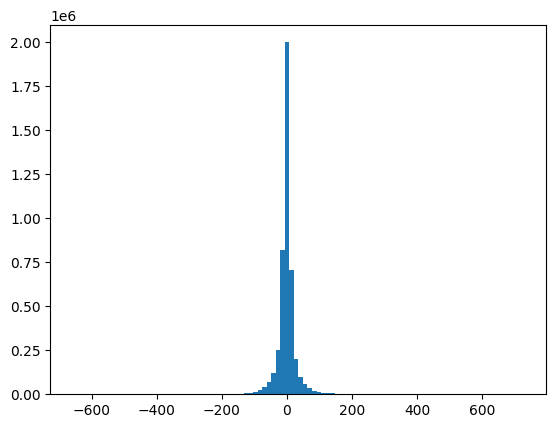

In [8]:
plt.hist(meanZstacks.flatten()-meanZstacks_cv.flatten(), bins=100)

print(np.sum(meanZstacks-meanZstacks_cv))

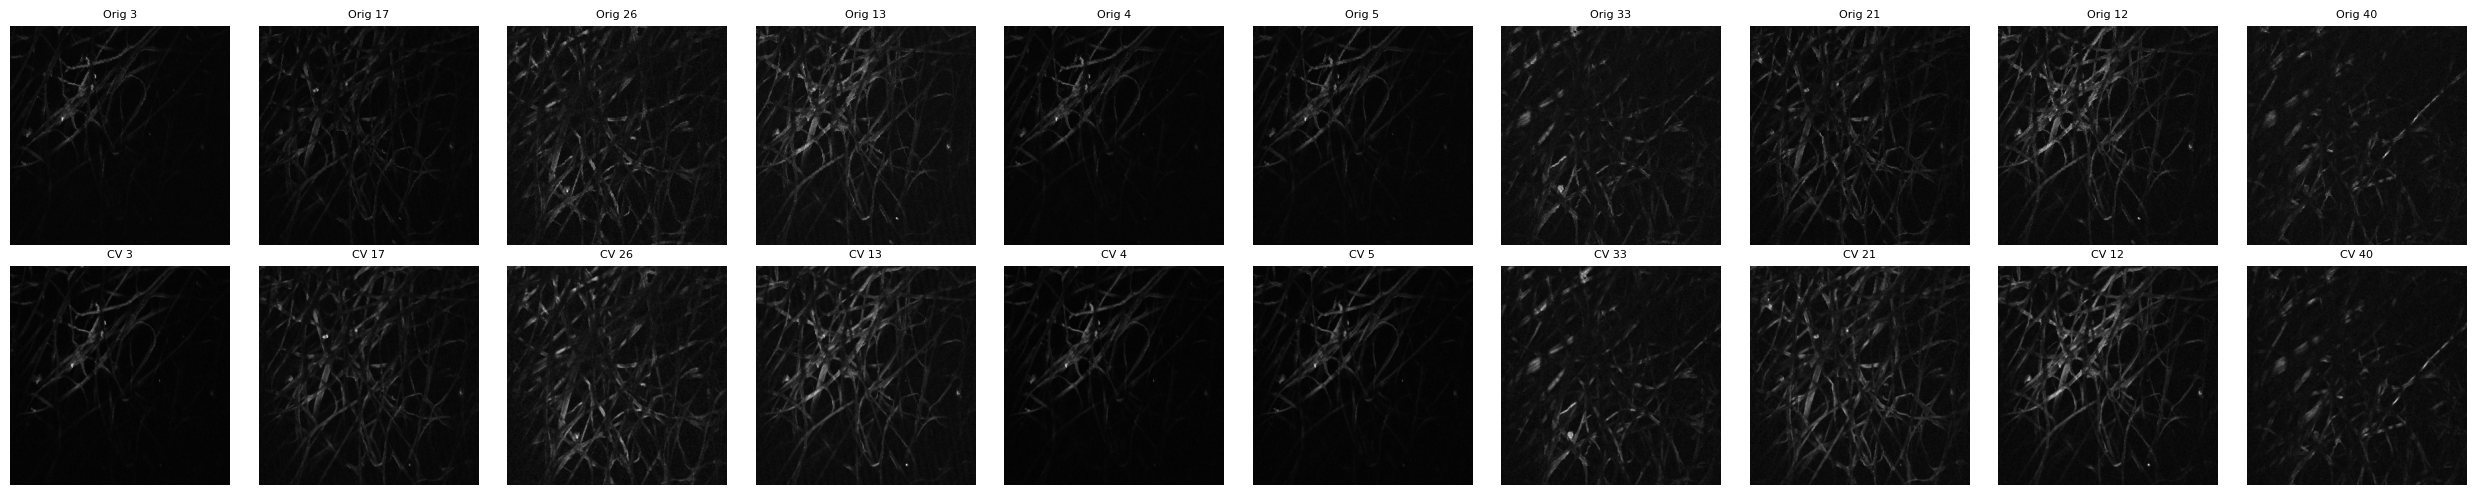

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# pick 10 random stacks
n_show = 10
idxs = np.random.choice(meanZstacks.shape[0], size=n_show, replace=False)

fig, axes = plt.subplots(2, n_show, figsize=(2.5*n_show, 5))
for j, idx in enumerate(idxs):
    axes[0, j].imshow(meanZstacks[idx], cmap='gray')
    axes[0, j].set_title(f"Orig {idx+1}", fontsize=8)
    axes[0, j].axis('off')

    axes[1, j].imshow(meanZstacks_cv[idx], cmap='gray')
    axes[1, j].set_title(f"CV {idx+1}", fontsize=8)
    axes[1, j].axis('off')

plt.tight_layout()
plt.show()


